In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch


In [16]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [30]:
import math
from math import exp

class Value:
  
  def __init__(self, data, label='', _op='', _children=() ):
    self.data = data
    self.label = label
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None

  def adapt_other(self, other):
    if not isinstance(other, Value):
      other = Value(other)
    return other
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = self.adapt_other(other)
    out = Value(self.data + other.data, _children=(self, other), _op='+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward
    return out
  
  def __mul__(self, other):
    other = self.adapt_other(other)
    out = Value(self.data * other.data, _children=(self, other), _op='*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, _children=(self,), _op=f'**{other}')
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __rdiv__(self, other): # other / self
    return other * self**-1

  def exp(self):
    out = Value(exp(self.data), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def log(self):
    out = Value(math.log(self.data), _children=(self,), _op='log')
    def _backward():
      self.grad += (1.0 / self.data) * out.grad
    out._backward = _backward
    return out
  
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self, ), _op='tanh')
    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward
    return out

  def backward(self):
      
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
      
def get_deriv(get_fcn, deriv=""):
  
  h=0.0001
  deriv_val = (get_fcn(h, deriv=deriv).data - get_fcn(0, deriv=deriv).data) / h
  print(f"deriv_{deriv} = {deriv_val}")
  return deriv_val



  


deriv_a = 6.000000000021544
deriv_b = -4.000000000008441
deriv_c = -1.9999999999953388
deriv_d = -1.9999999999953388
deriv_e = -1.9999999999953388
deriv_f = 3.9999999999995595
deriv_L = 0.9999999999976694


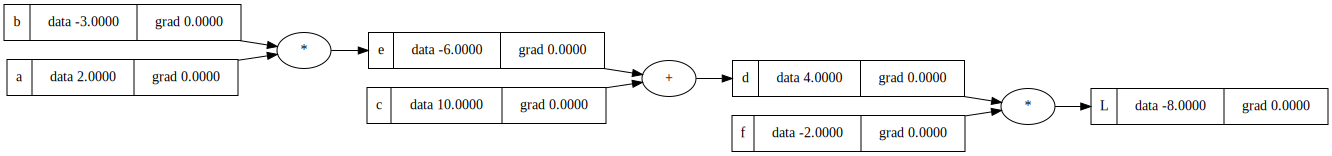

In [18]:
def get_L(h=0.0, deriv=""):
  
  ah=0
  bh=0
  ch=0
  dh=0
  eh=0
  fh=0
  Lh=0
  if h!=0:
    if deriv=="a":
      ah=h
    elif deriv=="b":
      bh=h
    elif deriv=="c":
      ch=h
    elif deriv=="d":
      dh=h
    elif deriv=="e":
      eh=h
    elif deriv=="f":
      fh=h
    elif deriv=="L":
      Lh=h

  a = Value(2.0 + ah, label='a')
  b = Value(-3.0 + bh, label='b')
  c = Value(10.0 + ch, label='c')
  e = a * b; e.label = 'e'; e.data += eh
  d = e + c; d.label = 'd'; d.data += dh
  f = Value(-2.0 + fh, label='f')
  L = d * f; L.label = 'L'; L.data += Lh
  
  return L



get_deriv(get_L,"a")
get_deriv(get_L,"b")
get_deriv(get_L,"c")
get_deriv(get_L,"d")
get_deriv(get_L,"e")
get_deriv(get_L,"f")
get_deriv(get_L,"L")

L = get_L()
draw_dot(L)

deriv_x1 = -1.500318220551966
deriv_x2 = 0.49996464549284525
deriv_w1 = 0.9998585853132624
deriv_w2 = 0.0
deriv_b = 0.49996464549284525
deriv_x1w1 = 0.49996464549284525
deriv_x2w2 = 0.49996464549284525
deriv_x1w1x2w2 = 0.49996464549284525
deriv_n = 0.4999646454939555
deriv_o = 0.9999999999998899


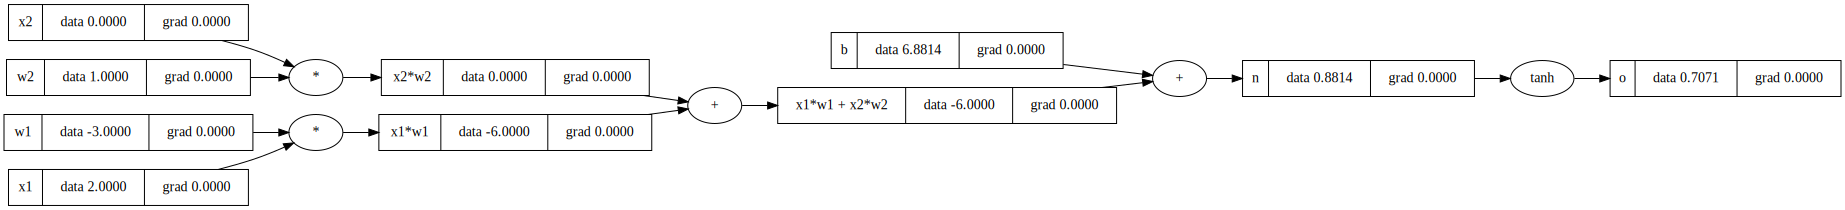

In [19]:
def get_o(h=0.0, deriv=""):
  
  x1h=0
  x2h=0
  w1h=0
  w2h=0
  bh=0
  x1w1h=0
  x2w2h=0
  x1w1x2w2h=0
  nh=0
  oh=0
  if h!=0:
    if deriv=="x1":
      x1h=h
    elif deriv=="x2":
      x2h=h
    elif deriv=="w1":
      w1h=h
    elif deriv=="w2":
      w2h=h
    elif deriv=="b":
      bh=h
    elif deriv=="x1w1":
      x1w1h=h
    elif deriv=="x2w2":
      x2w2h=h
    elif deriv=="x1w1x2w2":
      x1w1x2w2h=h
    elif deriv=="n":
      nh=h
    elif deriv=="o":
      oh=h

  # inputs x1,x2
  x1 = Value(2.0 + x1h, label='x1')
  x2 = Value(0.0 + x2h, label='x2')
  # weights w1,w2
  w1 = Value(-3.0 + w1h, label='w1')
  w2 = Value(1.0 + w2h, label='w2')
  # bias of the neuron
  b = Value(6.8813735870195432 + bh, label='b')
  # x1*w1 + x2*w2 + b
  x1w1 = x1*w1; x1w1.label = 'x1*w1'; x1w1.data += x1w1h
  x2w2 = x2*w2; x2w2.label = 'x2*w2'; x2w2.data += x2w2h
  x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'; x1w1x2w2.data += x1w1x2w2h
  n = x1w1x2w2 + b; n.label = 'n'; n.data += nh
  o = n.tanh(); o.label = 'o'; o.data += oh
    
  return o


get_deriv(get_o, "x1")
get_deriv(get_o, "x2")
get_deriv(get_o, "w1")
get_deriv(get_o, "w2")
get_deriv(get_o, "b")
get_deriv(get_o, "x1w1")
get_deriv(get_o, "x2w2")
get_deriv(get_o, "x1w1x2w2")
get_deriv(get_o, "n")
get_deriv(get_o, "o")

o = get_o()
draw_dot(o)

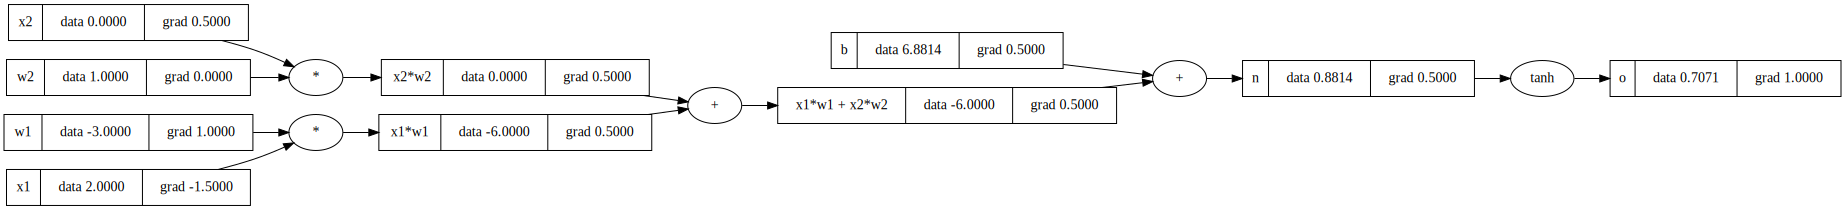

In [20]:
o.backward()
draw_dot(o)

In [21]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi,xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    



In [23]:
x = [2.0, 3.0]

n = Neuron(3)
n(x)

l = Layer(3, 4)
l(x)

mlp = MLP(3, [4, 4, 1])
mlp(x)

# draw_dot(mlp(x))

Value(data=0.8987170907861508)

In [24]:
xs = [
  [2.0, 3.0],
  [3.0, -1.0],
  [0.5, 1.0],
  [1.0, 1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ys_pred = [mlp(x) for x in xs]
ys_pred

[Value(data=0.8987170907861508),
 Value(data=0.8112719340835639),
 Value(data=0.9229028394371485),
 Value(data=0.9157433833819205)]

In [25]:
losses = [((y_p - y_t)**2) for y_p, y_t in zip(ys_pred, ys)]
print(losses)

loss = sum(losses)
print(loss)

loss.backward()

# draw_dot(loss)

[Value(data=0.010258227698820817), Value(data=3.2807060191988144), Value(data=3.6975553299154473), Value(data=0.007099177443926028)]
Value(data=6.995618754257009)


In [26]:
for k in range(1000):

    # forward pass
    ys_pred = [mlp(x) for x in xs]
    loss = sum((y_p - y_t)**2 for y_p, y_t in zip(ys_pred, ys))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update	
    for p in mlp.parameters():
        p.data -= p.grad * 0.01

    print(k, loss.data)

ys_pred
    

0 6.995618754257009
1 6.6480363394482795
2 6.170239799790147
3 5.627357170030514
4 5.0987676416628025
5 4.618759280158668
6 4.205181734577769
7 3.875701208005333
8 3.6382193038803803
9 3.4814750540865003
10 3.380731313967157
11 3.3118111471098066
12 3.258708843475453
13 3.2130549294424346
14 3.171075019448401
15 3.1312293111433656
16 3.092935811224608
17 3.055985788851861
18 3.0203017147647784
19 2.9858447574560363
20 2.952582532115584
21 2.920479515572684
22 2.889495337607094
23 2.8595854739324453
24 2.830702454490033
25 2.8027970067934285
26 2.7758189981864687
27 2.7497181767269723
28 2.7244447431958623
29 2.699949788501567
30 2.676185625102309
31 2.6531060349279114
32 2.630666451239116
33 2.6088240879987277
34 2.5875380274063042
35 2.5667692740257375
36 2.5464807822299713
37 2.5266374623681616
38 2.5072061700329664
39 2.488155681999782
40 2.469456661772681
41 2.4510816171633145
42 2.433004851918196
43 2.4152024130727496
44 2.3976520354292963
45 2.3803330843170407
46 2.36322649758479

[Value(data=0.9980148184793345),
 Value(data=-0.9702948900831069),
 Value(data=-0.9358972665727132),
 Value(data=0.9304231893206775)]

In [27]:
mlp([0, 0])

Value(data=-0.9984360923785593)

In [37]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
  return [
      -3*a**2 - 0.5*a**(-0.5)
      , 3*cos(3*b) + 2.5*b**1.5
      , c**-2
  ] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of 
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")
print("--------------------------------")

# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
a=2
b=3
c=4
h=0.000001
numerical_grad = [
    (f(a+h, b, c) - f(a, b, c)) / h,
    (f(a, b+h, c) - f(a, b, c)) / h,
    (f(a, b, c+h) - f(a, b, c)) / h
] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")
print("--------------------------------")


# there is an alternative formula that provides a much better numerical 
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
numerical_grad2 = [
    (f(a+h, b, c) - f(a-h, b, c)) / (2*h),
    (f(a, b+h, c) - f(a, b-h, c)) / (2*h),
    (f(a, b, c+h) - f(a, b, c-h)) / (2*h),
] # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")
print("--------------------------------")


# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")
print("--------------------------------")


# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

logits = torch.Tensor([0.0, 3.0, -2.0, 1.0]).double(); logits.requires_grad = True
probs = torch.softmax(logits, dim=0)
loss = -torch.log(probs[3])  # dim 3 acts as the label for this input example
loss.backward()

for dim in range(4):
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits.grad[dim]}")
print("--------------------------------")







6.336362190988558
OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625
--------------------------------
OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534
--------------------------------
OK for dim 0: expected -12.353553390593273, yours returns -12.353553391353245
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027401572
OK for dim 2: expected 0.0625, yours returns 0.06250000028629188
--------------------------------
2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.0056533